# Classification of Cancer associated Mutations from Literature using Machine Learning

Use the "Run" button to execute the code.

In [2]:
pip install jovian --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.


distutils: C:\Users\anubr\anaconda3\Include\UNKNOWN
sysconfig: C:\Users\anubr\anaconda3\Include
user = False
home = None
root = None
prefix = None
distutils: C:\Users\anubr\anaconda3\Include\UNKNOWN
sysconfig: C:\Users\anubr\anaconda3\Include
user = False
home = None
root = None
prefix = None


In [3]:
# Execute this to save new versions of the notebook
jovian.commit(project="jovian-ml-project",filename="jovian-ml-project")

<IPython.core.display.Javascript object>

[jovian] Updating notebook "anubratadas/jovian-ml-project-rough" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/anubratadas/jovian-ml-project-rough


'https://jovian.ai/anubratadas/jovian-ml-project-rough'

### <font color='green'>Import the essential libraries</font>

In [4]:
import jovian
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import xml.etree.ElementTree as ET
import time
import re
from tqdm import tqdm
%matplotlib inline

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.simplefilter(action='ignore')

In [6]:
tqdm.pandas(desc="progress bar")

 ### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height: 0.8;word-spacing: 10px"> A cancerous tissue can have thousands of genetic mutations (Variations), which are discovered using genome sequencing. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature. For this competition MSKCC is making available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations. MSKCC intends the Data scientist to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.</font>

<a id='top'>**Beginning of Notebook**</a>

[model train text data](#train_data)

### <font color='green'>Exploratory Data Analysis</font>

###  references
  - https://github.com/ghostintheshellarise/2021HackForRare
  - https://widdowquinn.github.io/2018-03-06-ibioic/02-sequence_databases/09-KEGG_programming.html
  - https://bioservices.readthedocs.io/en/master/kegg_tutorial.html
  - https://bioservices.readthedocs.io/en/master/index.html

#### train data

In [7]:
train_text_df = pd.read_csv('training_text.zip', sep="\|\|", encoding="utf-8",engine="python", skiprows=1, names=["ID", "Text"],compression='zip')

In [8]:
train_variant_df = pd.read_csv('training_variants.zip',compression='zip')

In [9]:
train_text_df.shape, train_variant_df.shape

((3321, 2), (3321, 4))

In [10]:
train_text_df.columns, train_variant_df.columns

(Index(['ID', 'Text'], dtype='object'),
 Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object'))

In [11]:
# merging the text and variation data
train_df = pd.merge(train_variant_df,train_text_df,on='ID')

In [12]:
train_df.shape

(3321, 5)

In [13]:
# taking a sample of the dataset
train_df = train_df.sample(frac=0.4,random_state=222)

We have taken a sample of the training data

In [14]:
train_df.head()

,ID,Gene,Variation,Class,Text
1708,1708,POLE,S459del,1,Tumors with somatic mutations in the proofread...
2201,2201,PTEN,D92A,4,The PTEN (phosphatase and tensin homolog) phos...
84,84,RIT1,A77T,2,Abstract RASopathies are autosomal dominant d...
1985,1985,CTNNB1,I35S,7,To understand the nature and roles of mutated ...
2985,2985,KIT,W557R,7,Purpose: Somatic mutations that result in the ...


### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height: 0.8;word-spacing: 10px"><i>Gene</i> is a stretch of DNA encoding a specific function. Variation is <i>Mutation</i>,  which changes the function. The first alphabet is the orginal amino acid, the number is the physical position in the gene where the change has occured and the last alphabet is the changed amino acid. The Text contains the information for the Gene, the Variation and the reason for the Class </font>

#### top 10 mutated genes

In [15]:
# top 10 mutated genes
train_df.groupby('Gene')['Variation'].aggregate("count").sort_values(ascending=False).head(n=10)

Gene
BRCA1     101
TP53       69
EGFR       56
BRCA2      56
PTEN       52
KIT        45
BRAF       40
ALK        28
PDGFRA     27
ERBB2      27
Name: Variation, dtype: int64

In [154]:
mutated_genes=train_df['Gene'].to_list()

### Importing Biopython library for pathway analysis

In [155]:
from Bio import SeqIO
from Bio.KEGG import REST
from bioservices.kegg import KEGG
from collections import deque
import networkx as nx
from IPython.display import Image
import time
import io
import os
from itertools import chain

ModuleNotFoundError: No module named 'Bio'

#### distribution of classes in the dataset

<AxesSubplot:xlabel='Class'>

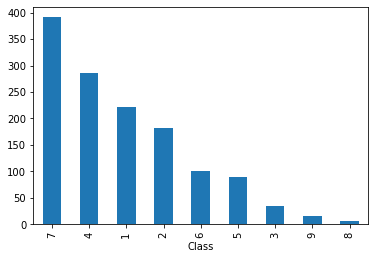

In [16]:
train_df.value_counts('Class').plot(kind='bar')

### <font color='blue'>The mutations are distributed into 9 classes from class 1 to class 9.The distribution of the classes is imbalanced </font>

### <font color='green'> Let us study the mutations of BRCA1, the most highly mutated gene with respect to the classification</font>

In [17]:
train_df[train_df['Gene'] == 'BRCA1']['Variation'].nunique()

101

In [18]:
train_df[train_df['Gene'] == 'BRCA1']['Class'].nunique()

5

In [19]:
train_df[train_df['Gene'] == 'BRCA1'].groupby('Class')['Variation'].count()

Class
1    21
3     3
4    22
5    36
6    19
Name: Variation, dtype: int64

### <font color='green'> 101 mutations (Variations) are classified into 5 classes with most mutations in class 5 and least mutations in class 3</font>

In [20]:
class_5=train_df[(train_df['Gene'] == 'BRCA1') & (train_df['Class']== 5)]
class_5['Text']=class_5['Text'].map(lambda x:x[:80])

In [21]:
class_5.reset_index(inplace=True,drop=True)

In [22]:
class_5

,ID,Gene,Variation,Class,Text
0,2661,BRCA1,S1613C,5,Abstract Germline mutations that inactivate B...
1,2460,BRCA1,R170W,5,Mutations in BRCA1 and BRCA2 account for the m...
2,2558,BRCA1,P1806A,5,ABSTRACT Germline mutations that inactivate th...
3,2618,BRCA1,C1787S,5,Abstract The BRCA1 gene from individuals at ...
4,2468,BRCA1,E362H,5,Mutations in BRCA1 and BRCA2 account for the m...
5,2673,BRCA1,S1473P,5,Abstract Germline inactivating mutations in B...
6,2472,BRCA1,L358R,5,Mutations in BRCA1 and BRCA2 account for the m...
7,2502,BRCA1,A1789S,5,Genetic screening of the breast and ovarian ca...
8,2423,BRCA1,A1830T,5,Genetic screening of the breast and ovarian ca...
9,2663,BRCA1,P1614S,5,Germ line inactivating mutations in BRCA1 conf...


In [23]:
class_5.groupby(['Text','Gene'],sort=False)['Variation'].count().reset_index()

,Text,Gene,Variation
0,Abstract Germline mutations that inactivate B...,BRCA1,2
1,Mutations in BRCA1 and BRCA2 account for the m...,BRCA1,15
2,ABSTRACT Germline mutations that inactivate th...,BRCA1,2
3,Abstract The BRCA1 gene from individuals at ...,BRCA1,6
4,Abstract Germline inactivating mutations in B...,BRCA1,3
5,Genetic screening of the breast and ovarian ca...,BRCA1,4
6,Germ line inactivating mutations in BRCA1 conf...,BRCA1,1
7,A significant proportion of inherited breast c...,BRCA1,1
8,BRCA1 is a tumour suppressor with pleiotropic ...,BRCA1,1
9,ABSTRACT: The BRCA1 tumor suppressor gene is f...,BRCA1,1


### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height:0.8;word-spacing:10px">What is the relationship of the enlisted mutations (Variation) of a gene and the corresponding 'Text' ? For e.g, for mutations of BCRA1, there are 36 unique mutations assigned to class 5 and the above 10 texts are the basis for it</font>

In [24]:
train_df.isna().sum()

ID           0
Gene         0
Variation    0
Class        0
Text         4
dtype: int64

In [25]:
train_df[train_df['Text'].map(lambda x:not isinstance(x,str))]

,ID,Gene,Variation,Class,Text
1407,1407,FGFR3,K508M,6,NaN
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1639,1639,FLT1,Amplification,6,NaN


In [26]:
train_df.dropna(inplace=True)

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
y_train=train_df['Class']
X_train=train_df.drop('Class',axis=1)
train_df,validation_df,y_train,y_validation=train_test_split(X_train,y_train,test_size=0.3)

In [29]:
train_df.shape,y_train.shape

((926, 4), (926,))

In [30]:
validation_df.shape,y_validation.shape

((398, 4), (398,))

### <font color='green'>analyzing the train text data</font>

[link to destination](#destination)

In [31]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [32]:
revised_punctuation='!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [33]:
revised_punctuation

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [34]:
#!pip install nltk

In [35]:
import nltk
nltk.download('words')
from nltk.corpus import words
words=nltk.corpus.words.words()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\anubr\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [36]:
len(set(words))

235892

In [37]:
nltk_words=set(words)

In [38]:
def cleanse_data(data):        
    if isinstance(data,str):
        no_punctuation = [char for char in data.replace('\n',' ') if char not in revised_punctuation]
        no_punctuation_txt = ''.join(no_punctuation)                   
        return no_punctuation_txt
    else:
        return "NA"

In [39]:
def reduce_words(data):
    data = data.split()
    words = [word for word in data if word not in nltk_words]
    text = " ".join(words)
    return text    

In [40]:
def word_count(text):
    text_lst=text.split()
    vector = [text_lst.count(str(word)) for word in text_lst]
    return vector[:300]

In [41]:
from nltk.probability import FreqDist

we have obtained the frequency distribution of words using freqdist

In [42]:
def freq_dist(data):
    data=data.split(" ")
    freq=FreqDist(data) # gets word frequency
    freq=sorted(freq.items(),key=lambda x:x[1], reverse=True) # sorts words from highest to lowest frequency
    return [item[1] for item in freq][:300] # returns a fixed length of 300 words

In [43]:
# implementing bag of words

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

In [45]:
bow_vectorizer = CountVectorizer(stop_words='english',max_features=1600)

In [46]:
# implementing tf-idf

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [48]:
tfidf_vectorizer = TfidfVectorizer(
    min_df=1, max_features=1600, strip_accents='unicode',lowercase =True,
    analyzer='word', token_pattern=r'\w+', ngram_range=(1, 3), use_idf=True, 
    smooth_idf=True, sublinear_tf=True, stop_words = 'english')

In [49]:
# https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/03-TF-IDF-Scikit-Learn.html
# https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
# https://machinelearningmastery.com/multinomial-logistic-regression-with-python/
# https://www.kaggle.com/elemento/personalizedmedicine-rct

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
from sklearn.metrics import log_loss

In [52]:
# define the multinomial logistic regression model
bow_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
tfidf_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

<a id="train_data" style="font-size:22px">model train text sample data</a>

[Beginning of Notebook](#top)

#### text preprocessing

In [53]:
# remove punctuation
train_df['cleaned_text'] = train_df['Text'].progress_map(cleanse_data,na_action='ignore')

progress bar: 100%|██████████| 926/926 [00:08<00:00, 106.23it/s]


In [54]:
# filtering all common english words
train_df['cleaned_text'] = train_df['cleaned_text'].progress_map(reduce_words,na_action='ignore')

progress bar: 100%|██████████| 926/926 [00:03<00:00, 261.99it/s]


In [55]:
train_df['Text_len'] = train_df['Text'].map(lambda x:len(str(x)))
train_df['cleaned_text_len'] = train_df['cleaned_text'].map(lambda x:len(str(x)))

In [56]:
train_df.head()

,ID,Gene,Variation,Text,cleaned_text,Text_len,cleaned_text_len
2364,2364,STK11,A205T,To investigate whether genetic alteration of t...,To STK11LKB1 tumor-suppressor HNSCC encoding e...,13714,5806
301,301,TMPRSS2,TMPRSS2-ETV5 Fusion,Recurrent gene fusions involving oncogenic ETS...,Recurrent fusions involving oncogenic ETS fact...,28088,12899
369,369,TP53,S215G,p53 is a sequence-specific transcription facto...,p53 sequence-specific controlling genes partic...,130434,52908
2541,2541,BRCA1,V1809A,Abstract The BRCA1 gene from individuals at ...,Abstract BRCA1 individuals cancers mutations H...,58319,21201
1545,1545,ALK,D1091N,"In the era of personalized medicine, understan...",In personalized drivers oncogenesis characteri...,98840,39427


### <font color='green'>converting text to numbers</font>

In [57]:
train_df_corpus = train_df['cleaned_text'].tolist()

#### bag of words transformation

In [58]:
bow_vectorizer.fit(train_df_corpus)

CountVectorizer(max_features=1600, stop_words='english')

In [59]:
train_df_counts= bow_vectorizer.transform(train_df_corpus)

In [60]:
print("Vocabulary: ", bow_vectorizer.vocabulary_)

Vocabulary:  {'tumor': 1522, 'hnscc': 760, 'encoding': 580, 'exons': 618, 'intronic': 846, 'sequences': 1359, 'analyzed': 255, 'sequencing': 1360, 'specimens': 1410, 'missense': 991, 'loh': 910, 'polymorphisms': 1180, 'identified': 779, 'samples': 1335, 'causes': 360, 'affects': 223, 'constructs': 434, 'wild': 1577, 'type': 1528, 'vectors': 1557, 'created': 461, 'transfected': 1503, 'cells': 372, 'results': 1302, 'showed': 1366, 'proteins': 1224, 'described': 511, 'studies': 1430, 'suggests': 1441, 'keywords': 867, 'lkb1': 905, 'ha': 732, '11': 26, 'located': 908, 'et': 603, '1997': 56, 'germline': 709, 'mutations': 1025, '1998': 57, 'characterized': 381, 'increased': 811, 'developing': 517, 'tumors': 1525, '2000': 67, 'residues': 1295, '44': 123, 'tissues': 1488, 'leads': 888, 'indicating': 817, 'plays': 1173, '2002': 69, '2001': 68, 'interestingly': 842, 'developed': 516, '45': 124, 'weeks': 1574, 'observed': 1081, 'patients': 1130, 'suggested': 1440, 'animals': 259, 'humans': 772, '

In [61]:
train_df_counts.shape

(926, 1600)

In [62]:
train_df_counts

<926x1600 sparse matrix of type '<class 'numpy.int64'>'
	with 390780 stored elements in Compressed Sparse Row format>

In [63]:
X_train_bow = train_df_counts.todense()

In [64]:
X_train_bow.shape

(926, 1600)

In [65]:
X_train_bow

matrix([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  2],
        [ 0,  0,  1, ...,  0, 10,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  2,  0],
        [ 0,  0,  1, ...,  0,  3,  0]], dtype=int64)

#### tfidf transformation

In [66]:
tfidf_vectorizer.fit(train_df_corpus)

TfidfVectorizer(max_features=1600, ngram_range=(1, 3), stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w+')

In [67]:
X_train_tfidf = tfidf_vectorizer.transform(train_df_corpus)
X_train_tfidf = X_train_tfidf.toarray()

In [68]:
X_train_tfidf.shape

(926, 1600)

In [69]:
X_train_tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.08152506],
       [0.035149  , 0.        , 0.        , ..., 0.        , 0.04585165,
        0.        ],
       ...,
       [0.06477877, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.02176475,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.04047021,
        0.        ]])

### <font color='green'>creating baseline metrics using hard coded predicted values</font>

In [70]:
from numpy import random

In [71]:
# create a dummy y value for getting the baseline accuracy
y_dummy_1 = random.rand(926,9)

In [72]:
#y_dummy

In [73]:
y_train.head()

2364    4
301     2
369     4
2541    5
1545    2
Name: Class, dtype: int64

In [74]:
y_dummy_1[0,:]

array([0.04496419, 0.71280346, 0.33191532, 0.49201118, 0.80042988,
       0.35606582, 0.62574381, 0.70772706, 0.84167233])

In [75]:
# baseline loss metric value, random y values
log_loss(y_train,y_dummy_1)

2.4440209665409163

In [76]:
y_dummy_2=np.zeros((926,9),dtype='float')

In [77]:
y_dummy_2[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [78]:
# baseline loss metric value, all probabilites for y set to zero
log_loss(y_train,y_dummy_2)

2.197224577336219

In [79]:
# baseline loss metric value, all probabilites for y set to 0.4
y_dummy_3=np.full((926,9),0.4,dtype='float')

In [80]:
y_dummy_3[0,:]

array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])

In [81]:
log_loss(y_train,y_dummy_3)

2.1972245773362187

In [82]:
y_dummy_4=np.zeros((926,9),dtype='float')

In [83]:
y_dummy_4[:,0]=1.0

In [84]:
y_dummy_4[0,:]

array([1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [85]:
# baseline loss metric value,probability at index 1 set to 1.0 for all y
log_loss(y_train,y_dummy_4) 

28.832045521885494

In [86]:
# baseline loss metric value,probability at random indices set to 1.0 for all y
y_dummy_5=np.zeros((926,9),dtype='float')
count=0
for x in X_train_bow:
    new_y_val=np.random.randint(0,9)
    y_dummy_5[count,new_y_val]=1.    
    count=count+1  

In [87]:
y_dummy_5[0,:]

array([0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [88]:
log_loss(y_train,y_dummy_5)

30.212104621898128

In [89]:
# baseline loss metric value,probability at random indices set to 1.0 for all y
def get_dummy(train_df):
    y_dummy_5=np.zeros((926,9),dtype='float') # creating the probability matrix for y values
    count=0
    for x in train_df:                        # iterating through the training dataset
        new_y_val=np.random.randint(0,9)      # creating random values for substituting index values
        y_dummy_5[count,new_y_val]=1.         # setting the random index value as 1.0
        count=count+1  
    return y_dummy_5    

In [90]:
def simulate_dummy(train_df,y_train):    
    for i in range(10):
        y_dummy=get_dummy(train_df)
        print(log_loss(y_train,y_dummy))

In [91]:
simulate_dummy(train_df,y_train)

2.4417071504712315
2.4044082558762954
2.3671093612813596
2.4044082558762954
2.4044082558762954
2.4044082558762954
2.4044082558762954
2.4044082558762954
2.4417071504712315
2.4417071504712315


In [92]:
pd.DataFrame({"substitutions":["random","all zero","all 0.4","index 1","random index"],"log_loss":[2.49,2.19,2.19,28.59,2.4]})

,substitutions,log_loss
0,random,2.49
1,all zero,2.19
2,all 0.4,2.19
3,index 1,28.59
4,random index,2.40


### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height:0.8;word-spacing:10px">Thus the lowermost limit for log loss score for an inaccurate model returns a value of 2.4 and hence our models should return better scores</font> 

### <font color='blue'>Logistic Regression Model</font>

In [93]:
from sklearn.metrics import accuracy_score

#### <font color='blue'>Logistic Regression with bag of words transformation</font>

In [94]:
bow_model.fit(X_train_bow,y_train)

LogisticRegression(multi_class='multinomial')

In [95]:
sorted(bow_model.coef_.tolist()[0])[:5]

[-0.2506560013748209,
 -0.22057902498021176,
 -0.2046476006367541,
 -0.15470518508528774,
 -0.1507225958859195]

In [96]:
bow_model.classes_

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [97]:
bow_model.n_features_in_

1600

In [98]:
bow_model.intercept_

array([ 0.01173618,  0.01503935, -0.02182365, -0.01104388,  0.01106916,
        0.01349123,  0.00900931, -0.01414094, -0.01333677])

In [99]:
y_pred_train_bow = bow_model.predict_proba(X_train_bow)

In [100]:
y_pred_train_bow2=bow_model.predict(X_train_bow)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [101]:
log_loss(y_train,y_pred_train_bow)

0.15672235005555984

In [102]:
from sklearn.metrics import classification_report

In [103]:
target_names=['class 1','class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']

In [104]:
print(classification_report(y_train, y_pred_train_bow2, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.93      0.89      0.91       153
     class 2       0.96      0.94      0.95       121
     class 3       0.73      0.70      0.72        27
     class 4       0.94      0.94      0.94       207
     class 5       0.79      0.77      0.78        60
     class 6       0.88      0.94      0.91        68
     class 7       0.95      0.97      0.96       277
     class 8       1.00      1.00      1.00         5
     class 9       0.89      1.00      0.94         8

    accuracy                           0.92       926
   macro avg       0.90      0.91      0.90       926
weighted avg       0.92      0.92      0.92       926



In [105]:
from sklearn.metrics import plot_confusion_matrix

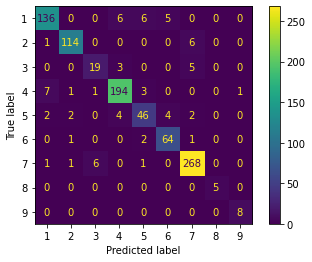

In [106]:
plot_confusion_matrix(bow_model, X_train_bow, y_train)

#### <font color='blue'>Logistic Regression with tfidf transformation</font>

In [107]:
tfidf_model.fit(X_train_tfidf,y_train)

LogisticRegression(multi_class='multinomial')

In [108]:
sorted(tfidf_model.coef_.tolist()[0])[:5]

[-0.8270794917220345,
 -0.684384218957839,
 -0.6544716521284297,
 -0.5823495425961271,
 -0.5590544323045477]

In [109]:
tfidf_model.classes_

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [110]:
tfidf_model.n_features_in_

1600

In [111]:
tfidf_model.intercept_

array([ 0.64611608,  1.07561475, -0.45356226,  1.23875073,  0.375886  ,
        0.33603029,  0.94900918, -2.30462496, -1.8632198 ])

In [112]:
y_pred_train_tfidf = tfidf_model.predict_proba(X_train_tfidf)

In [113]:
y_pred_train_tfidf2 = tfidf_model.predict(X_train_tfidf)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [114]:
log_loss(y_train,y_pred_train_tfidf)

0.9893387641254819

In [115]:
print(classification_report(y_train, y_pred_train_tfidf2, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.76      0.76      0.76       153
     class 2       0.90      0.37      0.53       121
     class 3       0.00      0.00      0.00        27
     class 4       0.77      0.82      0.79       207
     class 5       0.59      0.48      0.53        60
     class 6       0.94      0.65      0.77        68
     class 7       0.67      0.98      0.80       277
     class 8       0.00      0.00      0.00         5
     class 9       0.00      0.00      0.00         8

    accuracy                           0.73       926
   macro avg       0.51      0.45      0.46       926
weighted avg       0.72      0.73      0.70       926



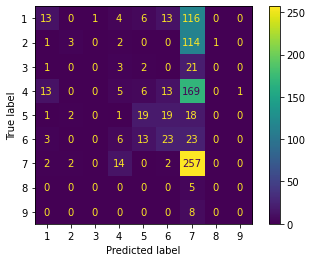

In [116]:
plot_confusion_matrix(tfidf_model, X_train_bow, y_train)

### <font color='blue'> Multinomial Naive Bayes Model<font>

In [117]:
from sklearn.naive_bayes import MultinomialNB

#### <font color='purple'>bag of words transformation</font>

In [118]:
NB_clf=MultinomialNB()

In [119]:
NB_clf.fit(X_train_bow,y_train)

MultinomialNB()

In [120]:
NB_clf.class_count_

array([153., 121.,  27., 207.,  60.,  68., 277.,   5.,   8.])

In [121]:
y_pred_train_NB=NB_clf.predict_proba(X_train_bow)

In [122]:
y_pred_train_NB2=NB_clf.predict(X_train_bow)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [123]:
log_loss(y_train,y_pred_train_NB)

11.237305657777807

In [124]:
print(classification_report(y_train, y_pred_train_NB2, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.61      0.76      0.68       153
     class 2       0.52      0.68      0.59       121
     class 3       0.35      0.70      0.47        27
     class 4       0.79      0.54      0.64       207
     class 5       0.52      0.57      0.54        60
     class 6       0.75      0.74      0.74        68
     class 7       0.81      0.60      0.69       277
     class 8       0.19      1.00      0.31         5
     class 9       0.57      1.00      0.73         8

    accuracy                           0.64       926
   macro avg       0.57      0.73      0.60       926
weighted avg       0.69      0.64      0.65       926



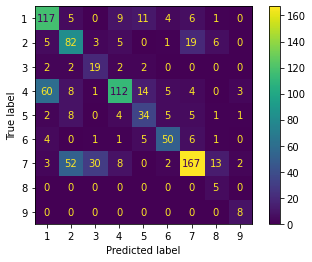

In [125]:
plot_confusion_matrix(NB_clf, X_train_bow, y_train)

### Validation dataset

In [126]:
validation_df.shape,y_validation.shape

((398, 4), (398,))

In [127]:
validation_df.head()

,ID,Gene,Variation,Text
2849,2849,BRCA2,H1966Y,Twenty percent of individuals with a strong fa...
1767,1767,IDH2,R172S,Monoallelic point mutations in cytosolic isoci...
2611,2611,BRCA1,V1808A,ABSTRACT Germline mutations that inactivate th...
1512,1512,ALK,D1203N,EML4–ALK fusions define a subset of lung cance...
1889,1889,MTOR,P2476L,Mammalian target of rapamycin (mTOR) is a seri...


#### text processing of validation data

In [128]:
# remove punctuation
validation_df['cleaned_text'] = validation_df['Text'].progress_map(cleanse_data,na_action='ignore')

progress bar: 100%|██████████| 398/398 [00:04<00:00, 99.15it/s] 


In [129]:
# filtering all common english words
validation_df['cleaned_text'] = validation_df['cleaned_text'].progress_map(reduce_words,na_action='ignore')

progress bar: 100%|██████████| 398/398 [00:01<00:00, 263.58it/s]


In [130]:
validation_df['Text_len'] = validation_df['Text'].map(lambda x:len(str(x)))
validation_df['cleaned_text_len'] = validation_df['cleaned_text'].map(lambda x:len(str(x)))

In [131]:
validation_df.head()

,ID,Gene,Variation,Text,cleaned_text,Text_len,cleaned_text_len
2849,2849,BRCA2,H1966Y,Twenty percent of individuals with a strong fa...,Twenty individuals andor BRCA1 BRCA2 Identific...,22651,8573
1767,1767,IDH2,R172S,Monoallelic point mutations in cytosolic isoci...,Monoallelic mutations cytosolic isocitrate 1 I...,77672,33988
2611,2611,BRCA1,V1808A,ABSTRACT Germline mutations that inactivate th...,ABSTRACT Germline mutations BRCA1 increased ca...,77981,29327
1512,1512,ALK,D1203N,EML4–ALK fusions define a subset of lung cance...,EML4–ALK fusions cancers treated ALK inhibitor...,92377,40625
1889,1889,MTOR,P2476L,Mammalian target of rapamycin (mTOR) is a seri...,Mammalian rapamycin mTOR serinethreonine regul...,19043,8410


In [132]:
validation_df_corpus = validation_df['cleaned_text'].tolist()

##### Bag of words transformation

In [133]:
validation_df_counts= bow_vectorizer.transform(validation_df_corpus)

In [134]:
validation_df_counts.shape

(398, 1600)

In [135]:
X_validation_bow = validation_df_counts.todense()

In [136]:
X_validation_bow.shape

(398, 1600)

In [137]:
X_validation_bow

matrix([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  5,  0],
        [ 0,  0,  0, ...,  4,  0, 11],
        [ 0,  0,  4, ...,  1, 20, 10]], dtype=int64)

In [138]:
y_pred_validation_bow = bow_model.predict_proba(X_validation_bow)

In [139]:
y_pred_validation_bow2 = bow_model.predict(X_validation_bow)

In [140]:
log_loss(y_validation,y_pred_validation_bow)

7.265635432181534

In [141]:
print(classification_report(y_validation, y_pred_validation_bow2, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.42      0.46      0.44        67
     class 2       0.53      0.51      0.52        61
     class 3       0.36      0.50      0.42         8
     class 4       0.53      0.51      0.52        79
     class 5       0.31      0.28      0.29        29
     class 6       0.78      0.45      0.57        31
     class 7       0.64      0.71      0.67       114
     class 8       0.00      0.00      0.00         1
     class 9       0.88      0.88      0.88         8

    accuracy                           0.54       398
   macro avg       0.49      0.48      0.48       398
weighted avg       0.55      0.54      0.54       398



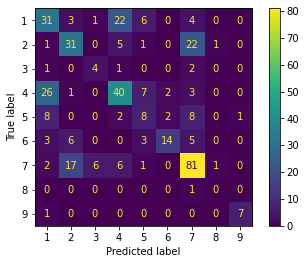

In [142]:
plot_confusion_matrix(bow_model, X_validation_bow, y_validation)

##### TFIDF transformation

In [143]:
X_validate_tfidf = tfidf_vectorizer.transform(validation_df_corpus)

In [144]:
X_validate_tfidf = X_validate_tfidf.toarray()

In [145]:
y_pred_validate_tfidf = tfidf_model.predict_proba(X_validate_tfidf)

In [146]:
y_pred_validate_tfidf2 = tfidf_model.predict(X_validate_tfidf)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [147]:
log_loss(y_validation,y_pred_validate_tfidf)

1.2843995965535149

In [148]:
print(classification_report(y_validation, y_pred_validate_tfidf2, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.53      0.48      0.50        67
     class 2       0.87      0.21      0.34        61
     class 3       0.00      0.00      0.00         8
     class 4       0.62      0.70      0.65        79
     class 5       0.40      0.34      0.37        29
     class 6       0.80      0.39      0.52        31
     class 7       0.57      0.96      0.71       114
     class 8       0.00      0.00      0.00         1
     class 9       0.00      0.00      0.00         8

    accuracy                           0.58       398
   macro avg       0.42      0.34      0.35       398
weighted avg       0.60      0.58      0.54       398



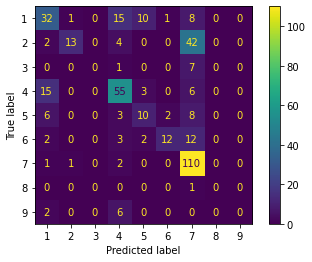

In [149]:
plot_confusion_matrix(tfidf_model, X_validate_tfidf, y_validation)

#### handling the test text sample data

In [ ]:
#test_text_df.sort_values(['ID']).head()

In [ ]:
#test_text_df.shape

In [ ]:
#test_text_df['cleaned_text'] = test_text_df['Text'].map(cleanse_data,na_action='ignore')

In [ ]:
#test_text_df['cleaned_text'] = test_text_df['cleaned_text'].map(reduce_words)

In [ ]:
#test_text_df['cleaned_text_vector'] = test_text_df['cleaned_text'].map(word_count)

In [ ]:
#test_text_df['sorted_cleaned_text_vector'] = test_text_df['cleaned_text'].progress_map(freq_dist)

In [ ]:
#test_text_df = test_text_df.drop(['Text'],axis=1)

In [ ]:
#test_text_df.head()

In [ ]:
# get the text samples as list
#test_corpus = test_text_df['cleaned_text'].tolist()

In [ ]:
# transform the test case to get bag of words
#test_bag_of_words_train = bow_vectorizer.fit_transform(test_corpus)

In [ ]:
# convert the dictionary to an array
#test_bag_of_words_array = test_bag_of_words_train.toarray()

In [ ]:
#test_bag_of_words_array.shape

In [ ]:
# predict test using bag of word model
#y_pred_test_bow = bow_model.predict_proba(test_bag_of_words_array)

In [ ]:
#y_pred_test_bow[0]

In [ ]:
#y_pred_test_df = pd.DataFrame(y_pred_test_bow)

In [ ]:
#test_text_df['ID'].shape

In [ ]:
#y_pred_test_df['ID']= test_text_df['ID'].reset_index(drop=True)

In [ ]:
#y_pred_test_df.head()

In [ ]:
# predict test using tfidf model
#y_pred_test_tfidf = tfidf_model.predict_proba(test_bag_of_words_array)

In [ ]:
stage2_test_text_df = pd.read_csv('stage2_test_text.csv', sep="\|\|", encoding="utf-8",engine="python", skiprows=1, names=["ID", "Text"])


In [ ]:
stage2_test_text_df.shape

In [ ]:
stage2_test_text_df['cleaned_text'] = stage2_test_text_df['Text'].progress_map(cleanse_data,na_action='ignore')

In [ ]:
stage2_test_text_df['cleaned_text'] = stage2_test_text_df['cleaned_text'].progress_map(reduce_words)

In [ ]:
stage2_test_text_df.shape

In [ ]:
stage2_cleaned_view =pd.DataFrame({"Text":stage2_test_text_df['Text'].progress_map(lambda x:len(x)),"cleaned_text":stage2_test_text_df['cleaned_text'].map(lambda x:len(x))})
stage2_cleaned_view.head()

In [ ]:
stage2_test_corpus = stage2_test_text_df['cleaned_text'].tolist()

In [ ]:
#X_stage2_test = bow_vectorizer.fit_transform(stage2_test_corpus).toarray()

In [ ]:
X_stage2_test = tfidf_vectorizer.fit_transform(stage2_test_corpus).toarray()

In [ ]:
X_stage2_test.shape

In [ ]:
y_pred_stage2 = tfidf_model.predict_proba(X_stage2_test)

In [ ]:
y_pred_stage2.shape

In [ ]:
y_pred_stage2_df = pd.DataFrame(y_pred_stage2)

In [ ]:
y_pred_stage2_df['ID']=stage2_test_text_df['ID']

In [ ]:
y_pred_stage2_df.columns

In [ ]:
y_pred_stage2_df.columns = ['class1','class2','class3','class4','class5','class6','class7','class8','class9','ID']

In [ ]:
y_pred_stage2_df=y_pred_stage2_df[['ID','class1','class2','class3','class4','class5','class6','class7','class8','class9']]

In [ ]:
y_pred_stage2_df.head()

In [ ]:
y_pred_stage2_df.to_csv("y_pred_stage2.csv",index=False)

In [ ]:
df=pd.DataFrame(columns=["Gene","Class","Variation","cleaned_text","cleaned_freq"])
for i in range(19):    
    df_new=class_9[class_9['cleaned_text'] == class_9['cleaned_text'].unique()[i]]
    df=pd.concat([df,df_new])

we have sorted the frequency dictionary based on values using the key parameter of sorted and higher values first using reverse

In [ ]:
sorted(test_dic.items(),key=lambda x:x[1], reverse=True)

In [ ]:
for i in range(10):
    print(scan_data1[i])

In [ ]:
cd /content

In [ ]:
pa_tree=ET.parse('pa2021.xml')

In [ ]:
root=pa_tree.getroot()

In [ ]:
# for child in root:
#   print(child.tag)

In [ ]:
for element_1 in root:
  #print("---------level_1-----------")
  #print(element_1.tag)
  
  for element_2 in element_1:
    #print("---------level_2-----------")
    #print("    "+element_2.tag," ",element_2.text)
    
    for element_3 in element_2:
      #print("---------level_3-----------")
      #print("        "+element_3.tag," ",element_3.text)
      
      for element_4 in element_3:
        #print("---------level_4-----------")
        if element_4.tag=="String":
          print("                   "+element_4.tag," ",element_4.text)
          
  #break
    

In [ ]:
len(root)

In [ ]:
desc_tree=ET.parse('desc2021.xml')

In [ ]:
desc_root=desc_tree.getroot()

In [ ]:
len(desc_root)

In [ ]:
term_description=[]
for element_1 in desc_root:
  #print("-------level_1----------")
  #print(element_1.tag," ",element_1.text)
  for element_2 in element_1:
    #print("    ----------level_2----------")
    #print("    "+element_2.tag," ",element_2.text)
    for element_3 in element_2:
      if element_3.tag=='String':
        #print("        ---------level_3--------")
        #print("        "+element_3.tag," ",element_3.text)
        term_description.append(element_3.text)

  #break

In [ ]:
len(term_description)

In [ ]:
term_description[:10]

In [ ]:
import csv 
with open('term_description.csv', 'w') as f: 
    write = csv.writer(f) 
    write.writerow(term_description) 
    

There are 2 ways to remove punctuation. one is to use the string library punctuation module on the text before tokenization, the other is to use the nltk.punct library

In [ ]:
len(scan_data1[1])

In [ ]:
#nltk.word_tokenize(scan_data1[1])

In [ ]:
# import string punctuation
import string
string.punctuation

In [ ]:
len(cleanup_text(scan_data1[1]))

In [ ]:
scan_data